In [1]:
import numpy as np
from numpy import pi as pi
import matplotlib.pyplot as plt

 - $G_\sigma(x,y) = \exp\{-d(x,y)^2/\sigma^2\}$, where $d(x,y)=|x-y|$ for positions, and for orientations, $d(x,y) = $ shortest distance around circle with $180^\circ$ circumference between $x$ and $y$
 - $N$ excitatory units and $N$ inhibitory units
 - Stimulus grating with orientation $\phi$ is $h(\theta) = G_{\sigma_{\text{FF}}}(\phi, \theta)$
 - Connection functions are $W_{ab} = J_{ab} G_{\sigma_{\text{ori}}}(\theta, \theta')$ for $a,b \in \{E, I\}.$
 
The input to excitatory neurons are given by the equation (in vector form)

$$
	\mathbf{I_E} = c\mathbf{h} + \mathbf{W_{EE}} \cdot \mathbf{r_E} + \mathbf{W_{EI}}\cdot \mathbf{r_I}.
$$

Similarly, 

$$
	\mathbf{I_I} = c\mathbf{h} + \mathbf{W_{IE}} \cdot \mathbf{r_E} + \mathbf{W_{II}}\cdot \mathbf{r_I}.
$$

Likewise, we can express the steady-state equations as 

\begin{align*}
	\mathbf{r_E^{SS}} &= k(\max\{\mathbf{I_E}, \mathbf{0}\})^n \\
	\mathbf{r_I^{SS}} &= k(\max\{\mathbf{I_I}, \mathbf{0}\})^n,
\end{align*}

where we interpret the $\max\{\mathbf{I_E}, \mathbf{0}\}$ above to be the component-wise maximum between $\mathbf{I_E}$ and $\mathbf{0}$. The firing rate ODEs are given by 

\begin{align*}
	\tau_E \frac{d\mathbf{r_E}}{dt} &= -\mathbf{r_E} + \mathbf{r_E^{SS}} \\
	\tau_I \frac{d\mathbf{r_I}}{dt} &= -\mathbf{r_I} + \mathbf{r_I^{SS}}.
\end{align*}

We also have to handle the distance function. Note that

$$
    d(x,y) = \min\{|x-y|, 180-|x-y|\}
$$

is a metric on $\left[0,180\right]$ with $0\sim 180.$ But this introduces non-differentiability. So consider a softmin function

$$ 
    \tilde{d}(x,y) = -\log(\exp\{-x\} + \exp\{-y\})
$$

Also, we can define a soft absolute value by perturbing $\sqrt{x^2}$ under the square root by some small $\varepsilon^2$:

$$
    |x| \approx \sqrt{x^2 + \varepsilon^2}.
$$

A smooth distance function we might use in the Gaussian could be 

$$ 
    d(x,y) = -\log(\exp\{-\sqrt{(x-y)^2+\varepsilon^2}\} + \exp\{-(180-\sqrt{(x-y)^2+\varepsilon^2})\})
$$

In [2]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

Testing this distance function:

In [3]:
d(0, 180)

-0.0

In [4]:
d(179, 1)

2.0

In [5]:
d(35, 175)

40.0

In [6]:
# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

In [7]:
# function to solve model equations via Euler method

def integrate(t0, T, dt, phi, N, tau_E, tau_I, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c):
    r_E = np.zeros((N,1)) # firing rate vector of E neurons
    r_I = np.zeros((N,1)) # firing rate vector of I neurons
    zero = np.zeros((N,1)) # Nx1 zero vector
    xs = np.linspace(0, 179, 180)
    
    R_E = r_E # these will store firing rates at each timestep as columns
    R_I = r_I 
    
    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # connectivity matrix G
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)
    W_EE = J_EE*G_ori
    W_EI = J_EI*G_ori
    W_IE = J_IE*G_ori
    W_II = J_II*G_ori
    
    I_E = c*h + W_EE@r_E + W_EI@r_I # initial inputs 
    I_I = c*h + W_IE@r_E + W_II@r_I
    rE_SS = k*(np.power(np.maximum(I_E, zero), n)) # initial steady state rates
    rI_SS = k*(np.power(np.maximum(I_I, zero), n))
    
    M = int(T/dt)
    ts = np.arange(M+1)
    for m in range(M):
        r_E = r_E + dt*(1/tau_E)*(-r_E + rE_SS)
        r_I = r_I + dt*(1/tau_I)*(-r_I + rI_SS)
        I_E = c*h + W_EE@r_E + W_EI@r_I 
        I_I = c*h + W_IE@r_E + W_II@r_I
        rE_SS = k*(np.power((np.maximum(I_E, zero)), n))
        rI_SS = k*(np.power((np.maximum(I_I, zero)), n))
        R_E = np.c_[R_E, r_E]
        R_I = np.c_[R_I, r_I]
        
    return r_E, r_I, R_E, R_I, xs, ts

In [13]:
r_E, r_I, R_E, R_I, xs, ts = integrate(t0=0, T=200, dt=0.1, phi=135, N=180, tau_E=20, tau_I=10, J_EE=0.044, J_II=-0.018, J_EI=-0.023, J_IE=0.042, sigma_ori=32, sigma_FF=30, k=0.04, n=2.0, c=50)

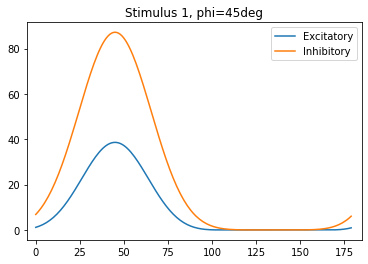

In [11]:
plt.plot(xs, r_E, label='Excitatory')
plt.plot(xs, r_I, label='Inhibitory')
plt.title('Stimulus 1, phi=45deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

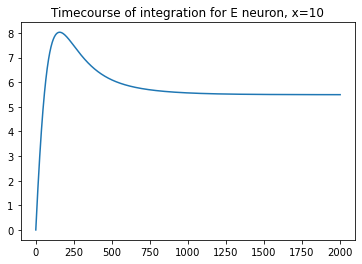

In [12]:
plt.title('Timecourse of integration for E neuron, x=10')
plt.plot(ts, R_E[10,:])
plt.show()

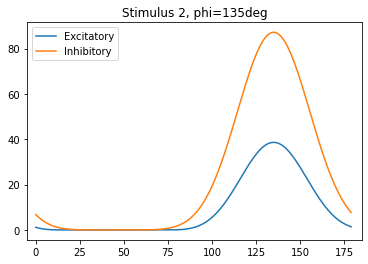

In [14]:
plt.plot(xs, r_E, label='Excitatory')
plt.plot(xs, r_I, label='Inhibitory')
plt.title('Stimulus 2, phi=135deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

In [15]:
E_rate = []
I_rate = []
cs=np.arange(100)
phi=45
for c in range(100):
    r_E, r_I, R_E, R_I, xs, ts = integrate(t0=0, T=200, dt=0.1, phi=phi, N=180, tau_E=20, tau_I=10, J_EE=0.044, J_II=-0.018, J_EI=-0.023, J_IE=0.042, sigma_ori=32, sigma_FF=30, k=0.04, n=2.0, c=c)
    E_rate.append(r_E[phi][0])
    I_rate.append(r_I[phi][0])

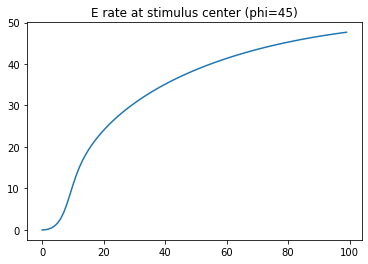

In [16]:
plt.title('E rate at stimulus center (phi=45)')
plt.plot(cs, E_rate)
plt.show()